In [1]:
import pickle as pkl
import viz_sequence
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
import h5py
from scipy.special import softmax
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF

#uncorrected model paths
model_25M="/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/ATAC/K562/4_4_shifted_ATAC_10.04.2021_bias_filters_500_subsample_25M/invivo_bias_model_step1/"
model_50M="/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/ATAC/K562/4_4_shifted_ATAC_10.05.2021_bias_filters_500subsample_50M/invivo_bias_model_step1/"
model_500M="/srv/scratch/anusri/chrombpnet_paper/results/chrombpnet/ATAC/K562/4_4_shifted_ATAC_09.29.2021_bias_filters_500/invivo_bias_model_step1/"

import numpy as np
from scipy.stats import entropy

In [2]:
def load_data(model_path):
    pfile=model_path+"model.0.predictions"
    f=h5py.File(pfile,'r')
    counts_labels=f['lab_1'][:]
    counts_pred=f['pred_1'][:]
    profile_labels=f['lab_0'][:]
    profile_pred=f['pred_0'][:]
    coord=f['coords'][:]
    coord_fixed=[[i.decode('utf8')  for i in j] for j in coord]
    coord_fixed=[[i.decode('utf8')  for i in j] for j in coord]
    print(coord_fixed[0])
    profile_pred_softmax=softmax(profile_pred,axis=1)
    return counts_labels, counts_pred, profile_labels, profile_pred_softmax

In [3]:
counts_labels_500M, counts_pred_500M, profile_labels_500M, profile_pred_softmax_500M = load_data(model_500M)
counts_labels_50M, counts_pred_50M, profile_labels_50M, profile_pred_softmax_50M = load_data(model_50M)
counts_labels_25M, counts_pred_25M, profile_labels_25M, profile_pred_softmax_25M = load_data(model_25M)

['chr1', '207973108', '.']
['chr1', '207973108', '.']
['chr1', '207973108', '.']


In [4]:
def jsd_pred(profile1_preds, profile2_preds):
    jsd_vals=[]
    for i in range(profile1_preds.shape[0]):
        jsd_val = jensenshannon(profile1_preds[i], profile2_preds[i])
        if not np.isnan(jsd_val):
            jsd_vals.append(jsd_val)
    
    return [np.mean(jsd_vals), np.std(jsd_vals)], jsd_vals

In [5]:
# pearsonr with observed 500M
print("observed 500M vs observed 50M counts pearsonr", pearsonr(counts_labels_500M, counts_labels_50M))
print("observed 500M vs observed 25M counts pearsonr", pearsonr(counts_labels_500M, counts_labels_25M))
print("\n")

# spearmanr with observed 500M
print("observed 500M vs observed 50M counts pearsonr", spearmanr(counts_labels_500M, counts_labels_50M))
print("observed 500M vs observed 25M counts pearsonr", spearmanr(counts_labels_500M, counts_labels_25M))
print("\n")

# JSD with observed 500M


stats_o500M_vs_o50M, vals_o500M_vs_o50M = jsd_pred(profile_labels_500M, profile_labels_50M)
print("observed 500M vs predicted 50M  JSD", stats_o500M_vs_o50M)

stats_o500M_vs_o25M, vals_o500M_vs_o25M = jsd_pred(profile_labels_500M, profile_labels_25M)
print("observed 500M vs predicted 25M  JSD", stats_o500M_vs_o25M)



observed 500M vs observed 50M counts pearsonr (0.8205134721634011, 0.0)
observed 500M vs observed 25M counts pearsonr (0.6901375149631064, 0.0)


observed 500M vs observed 50M counts pearsonr SpearmanrResult(correlation=0.9158037209951567, pvalue=0.0)
observed 500M vs observed 25M counts pearsonr SpearmanrResult(correlation=0.8452722838549543, pvalue=0.0)




/users/anusri/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1289: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=0)
/users/anusri/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1288: RuntimeWarning: invalid value encountered in true_divide
  p = p / np.sum(p, axis=0)


observed 500M vs predicted 50M  JSD [0.6844578448817544, 0.05135810869116152]
observed 500M vs predicted 25M  JSD [0.7391177706212666, 0.041711882764445485]


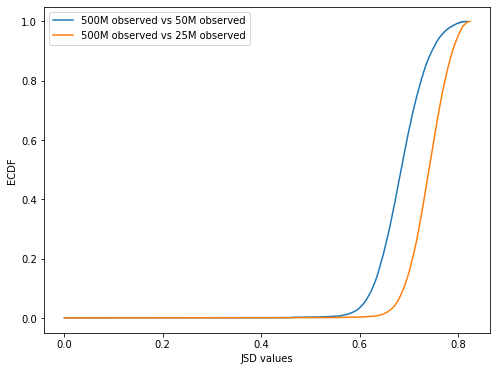

In [6]:
plt.figure(figsize=(8, 6))
ecdf = ECDF(vals_o500M_vs_o50M)
plt.plot(ecdf.x, ecdf.y,label="500M observed vs 50M observed")
ecdf = ECDF(vals_o500M_vs_o25M)
plt.plot(ecdf.x, ecdf.y,label="500M observed vs 25M observed")
plt.legend()
plt.xlabel("JSD values")
plt.ylabel("ECDF")
plt.show()

In [7]:
np.random.seed(1)
def normed_jsd(profile_preds, profile_preds_500M, obs_500M):
    jsd_vals=[]
    for i in range(profile_preds.shape[0]):
        x = jensenshannon(profile_preds[i], obs_500M[i])
        max_v = jensenshannon(profile_preds_500M[i], obs_500M[i])
        #j = np.random.choice(list( range(profile_preds.shape[0])),1)[0]
        #min_v = jensenshannon(profile_preds[i], obs_500M[j])
        #print(x, max_v, min_v)
        if not np.isnan(x):
            jsd_vals.append((x-1)/(max_v-1))
        #break
    
    return [np.mean(jsd_vals), np.std(jsd_vals)], jsd_vals
    

In [8]:
# normed JSD with observed 500M

norm_stats_o500M_vs_o50M, norm_vals_o500M_vs_o50M = normed_jsd(profile_pred_softmax_50M,profile_pred_softmax_500M,profile_labels_500M)
print("observed 500M vs predicted 50M  JSD", norm_stats_o500M_vs_o50M)

norm_stats_o500M_vs_o25M, norm_vals_o500M_vs_o25M = normed_jsd(profile_pred_softmax_25M,profile_pred_softmax_500M,profile_labels_500M)
print("observed 500M vs predicted 25M  JSD", norm_stats_o500M_vs_o25M)


/users/anusri/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1289: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=0)


observed 500M vs predicted 50M  JSD [0.9878129873517659, 0.017845562277112405]
observed 500M vs predicted 25M  JSD [0.9830452700327156, 0.01659016553210746]


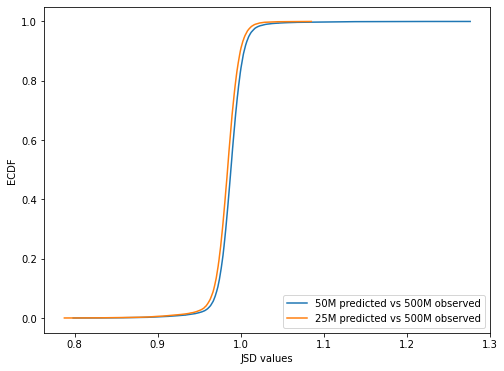

In [9]:
plt.figure(figsize=(8, 6))
#plt.hist(norm_vals_o500M_vs_o100M)
ecdf = ECDF(norm_vals_o500M_vs_o50M)
plt.plot(ecdf.x, ecdf.y,label="50M predicted vs 500M observed")
ecdf = ECDF(norm_vals_o500M_vs_o25M)
plt.plot(ecdf.x, ecdf.y,label="25M predicted vs 500M observed")
#print(norm_vals_o500M_vs_o100M)
plt.legend()
plt.xlabel("JSD values")
plt.ylabel("ECDF")
plt.show()

In [10]:
np.random.seed(1)
def normed_jsd(profile_preds, profile_preds_500M, obs_500M):
    jsd_vals=[]
    for i in range(profile_preds.shape[0]):
        x = jensenshannon(profile_preds[i], obs_500M[i])
        max_v = jensenshannon(profile_preds_500M[i], obs_500M[i])
        j = np.random.choice(list( range(profile_preds.shape[0])),1)[0]
        min_v = jensenshannon(profile_preds[i], obs_500M[j])
        #print(x, max_v, min_v)
        if not np.isnan(x):
            jsd_vals.append((x-min_v)/(max_v-min_v))
        #break
    
    return [np.mean(jsd_vals), np.std(jsd_vals)], jsd_vals
    

In [11]:
# normed JSD with observed 500M

norm_stats_o500M_vs_o50M, norm_vals_o500M_vs_o50M = normed_jsd(profile_pred_softmax_50M,profile_pred_softmax_500M,profile_labels_500M)
print("observed 500M vs predicted 50M  JSD", norm_stats_o500M_vs_o50M)

norm_stats_o500M_vs_o25M, norm_vals_o500M_vs_o25M = normed_jsd(profile_pred_softmax_25M,profile_pred_softmax_500M,profile_labels_500M)
print("observed 500M vs predicted 25M  JSD", norm_stats_o500M_vs_o25M)


/users/anusri/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1289: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=0)


observed 500M vs predicted 50M  JSD [nan, nan]
observed 500M vs predicted 25M  JSD [nan, nan]


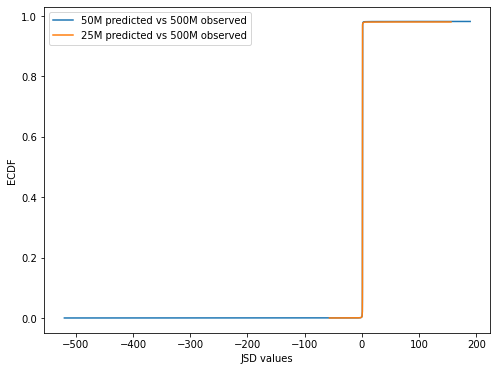

In [12]:
plt.figure(figsize=(8, 6))
ecdf = ECDF(norm_vals_o500M_vs_o50M)
plt.plot(ecdf.x, ecdf.y,label="50M predicted vs 500M observed")
ecdf = ECDF(norm_vals_o500M_vs_o25M)
plt.plot(ecdf.x, ecdf.y,label="25M predicted vs 500M observed")
plt.legend()
plt.xlabel("JSD values")
plt.ylabel("ECDF")
#plt.xlim(0,2)
plt.show()

In [13]:
# pearsonr with observed 500M
print("observed 500M vs predicted 500M counts pearsonr", pearsonr(counts_labels_500M, counts_pred_500M))
print("observed 500M vs predicted 50M counts pearsonr", pearsonr(counts_labels_500M, counts_pred_50M))
print("observed 500M vs predicted 25M counts pearsonr", pearsonr(counts_labels_500M, counts_pred_25M))
print("\n")

# spearmanr with observed 500M
print("observed 500M vs predicted 500M counts pearsonr", spearmanr(counts_labels_500M, counts_pred_500M))
print("observed 500M vs predicted 50M counts pearsonr", spearmanr(counts_labels_500M, counts_pred_50M))
print("observed 500M vs predicted 25M counts pearsonr", spearmanr(counts_labels_500M, counts_pred_25M))
print("\n")

# JSD with observed 500M
stats_o500M_vs_p500M, vals_o500M_vs_p500M = jsd_pred(profile_labels_500M, profile_pred_softmax_500M)
print("observed 500M vs predicted 500M JSD", stats_o500M_vs_p500M )


stats_o500M_vs_p50M, vals_o500M_vs_p50M = jsd_pred(profile_labels_500M, profile_pred_softmax_50M)
print("observed 500M vs predicted 50M  JSD", stats_o500M_vs_p50M)

stats_o500M_vs_p25M, vals_o500M_vs_p25M = jsd_pred(profile_labels_500M, profile_pred_softmax_25M)
print("observed 500M vs predicted 25M  JSD", stats_o500M_vs_p25M)


observed 500M vs predicted 500M counts pearsonr (0.5170475195778121, 0.0)
observed 500M vs predicted 50M counts pearsonr (0.2914617221092551, 0.0)
observed 500M vs predicted 25M counts pearsonr (0.247862159129459, 0.0)


observed 500M vs predicted 500M counts pearsonr SpearmanrResult(correlation=0.5903213395387559, pvalue=0.0)
observed 500M vs predicted 50M counts pearsonr SpearmanrResult(correlation=0.5616291139549, pvalue=0.0)
observed 500M vs predicted 25M counts pearsonr SpearmanrResult(correlation=0.5614810594167488, pvalue=0.0)




/users/anusri/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1288: RuntimeWarning: invalid value encountered in true_divide
  p = p / np.sum(p, axis=0)


observed 500M vs predicted 500M JSD [0.5650094941653269, 0.09378468154553075]
observed 500M vs predicted 50M  JSD [0.5704900979575183, 0.09226960132117297]
observed 500M vs predicted 25M  JSD [0.5724675944190416, 0.09221901082091298]


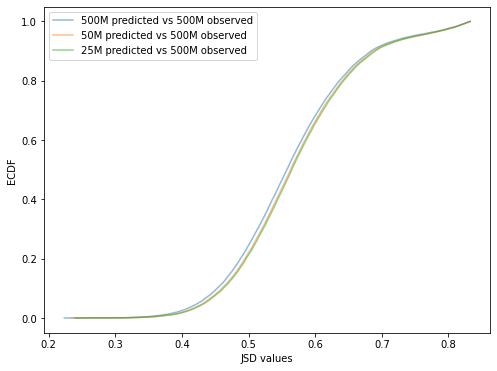

In [14]:
plt.figure(figsize=(8, 6))
ecdf = ECDF(vals_o500M_vs_p500M)
plt.plot(ecdf.x, ecdf.y,label="500M predicted vs 500M observed", alpha=0.5)
ecdf = ECDF(vals_o500M_vs_p50M)
plt.plot(ecdf.x, ecdf.y,label="50M predicted vs 500M observed", alpha=0.5)
ecdf = ECDF(vals_o500M_vs_p25M)
plt.plot(ecdf.x, ecdf.y,label="25M predicted vs 500M observed", alpha=0.5)
plt.legend()
plt.xlabel("JSD values")
plt.ylabel("ECDF")
plt.show()

In [15]:
# pearsonr with predicted 500M
print("predicted 500M vs predicted 50M counts pearsonr", pearsonr(counts_pred_500M, counts_pred_50M))
print("predicted 500M vs predicted 25M counts pearsonr", pearsonr(counts_pred_500M, counts_pred_25M))
print("\n")


# spearmanr with predicted 500M
print("predicted 500M vs predicted 50M counts pearsonr", spearmanr(counts_pred_500M, counts_pred_50M))
print("predicted 500M vs predicted 25M counts pearsonr", spearmanr(counts_pred_500M, counts_pred_25M))
print("\n")

# JSD with predicted 500M


stats_p500M_vs_p50M, vals_p500M_vs_p50M = jsd_pred(profile_pred_softmax_500M, profile_pred_softmax_50M)
print("predicted 500M vs predicted 50M  JSD", stats_p500M_vs_p50M)

stats_p500M_vs_p25M, vals_p500M_vs_p25M = jsd_pred(profile_pred_softmax_500M, profile_pred_softmax_25M)
print("predicted 500M vs predicted 25M  JSD", stats_p500M_vs_p25M)


predicted 500M vs predicted 50M counts pearsonr (0.5752361125305968, 0.0)
predicted 500M vs predicted 25M counts pearsonr (0.431973876097641, 0.0)


predicted 500M vs predicted 50M counts pearsonr SpearmanrResult(correlation=0.7073247265496867, pvalue=0.0)
predicted 500M vs predicted 25M counts pearsonr SpearmanrResult(correlation=0.6282096995839185, pvalue=0.0)


predicted 500M vs predicted 50M  JSD [0.11111387306073794, 0.029981758357455153]
predicted 500M vs predicted 25M  JSD [0.10958608439967608, 0.018335194713282134]


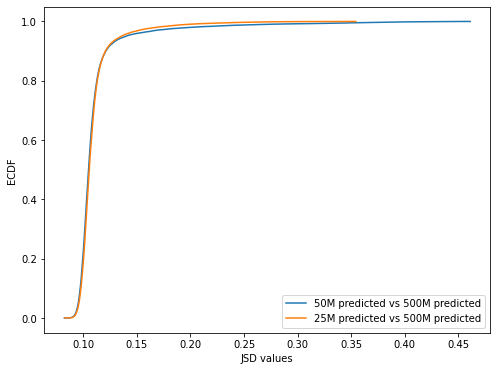

In [16]:
plt.figure(figsize=(8, 6))
ecdf = ECDF(vals_p500M_vs_p50M)
plt.plot(ecdf.x, ecdf.y,label="50M predicted vs 500M predicted")
ecdf = ECDF(vals_p500M_vs_p25M)
plt.plot(ecdf.x, ecdf.y,label="25M predicted vs 500M predicted")
plt.legend()
plt.xlabel("JSD values")
plt.ylabel("ECDF")
plt.show()

In [17]:
#print(len(counts_pred_25M))